<a href="https://colab.research.google.com/github/renanklehm/TrueSight/blob/main/TrueSight_(M5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#PARAMS#
USE_LR_FINDER = False
TRAIN_MODEL = True
LOAD_DF = True
LOAD_SAMPLES = True
lookback = 12
forecast_horizon = 12
batch_size = 1024
#master_path = "C:/Users/Renan/Forecast-Multivariado-M5/"
master_path = "drive/MyDrive/Forecast-M5/"

#PIP commands

In [2]:
#!pip install tslearn
#!pip install sktime
#!pip install pytorch_forecasting
#!pip install tensorflow==2.9

#Dataframe

In [3]:
import pandas as pd
if (LOAD_DF):
    df = pd.read_csv(f"{master_path}finished-df.csv")
    feats = pd.read_csv(f"{master_path}features.csv", thousands = ".")
    feats.dropna(axis = 1, inplace = True)
    #feats.drop(["id", "dept_id"], axis = 1, inplace = True)
    df["time_idx"] = df["time_idx"].astype(int)
    df["id"] = df["id"].astype("category")
    df["item_id"] = df["item_id"].astype("category")
    df["dept_id"] = df["dept_id"].astype("category")
    df["cat_id"] = df["cat_id"].astype("category")
    df["store_id"] = df["store_id"].astype("category")
    df["state_id"] = df["state_id"].astype("category")
    df["time_idx"] = df["time_idx"].astype("int16")
    df["sales"] = df["sales"].astype("int32")
    #df["wm_yr_wk"] = df["wm_yr_wk"].astype("int16")
    #df["sell_price"] = df["sell_price"].astype("float32")
    #df["date"] = pd.to_datetime(df["date"])
    #df["wm_yr_wk"] = df["wm_yr_wk"].astype("int16")
    #df["wday"] = df["wday"].astype("int16")
    df["month"] = df["month"].astype("int16")
    df["year"] = df["year"].astype("int16")
else:
    df = pd.read_csv(f"{master_path}sales_train_validation.csv")
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"], var_name="time_idx", value_name="sales")
    df["time_idx"] = df["time_idx"].astype(int)
    df["id"] = df["id"].astype("category")
    df["item_id"] = df["item_id"].astype("category")
    df["dept_id"] = df["dept_id"].astype("category")
    df["cat_id"] = df["cat_id"].astype("category")
    df["store_id"] = df["store_id"].astype("category")
    df["state_id"] = df["state_id"].astype("category")
    df["time_idx"] = df["time_idx"].astype("int16")
    df["sales"] = df["sales"].astype("int32")
    sell_prices = pd.read_csv(f"{master_path}sell_prices.csv")
    sell_prices["id"] = sell_prices["item_id"] + "_" + sell_prices["store_id"] + "_validation"
    sell_prices = sell_prices[["id", "sell_price", "wm_yr_wk"]]
    sell_prices["id"] = sell_prices["id"].astype("category")
    sell_prices["wm_yr_wk"] = sell_prices["wm_yr_wk"].astype("int16")
    sell_prices["sell_price"] = sell_prices["sell_price"].astype("float32")
    calendar = pd.read_csv(f"{master_path}calendar.csv")
    calendar = calendar[["date", "wm_yr_wk", "wday", "month", "year", "time_idx"]]
    calendar["date"] = pd.to_datetime(calendar["date"])
    calendar["wm_yr_wk"] = calendar["wm_yr_wk"].astype("int16")
    calendar["wday"] = calendar["wday"].astype("int16")
    calendar["month"] = calendar["month"].astype("int16")
    calendar["year"] = calendar["year"].astype("int16")
    calendar["time_idx"] = calendar["time_idx"].astype("int16")
    df = df.merge(calendar, on = "time_idx", how = "left")
    df = df.merge(sell_prices, on = ["id", "wm_yr_wk"], how = "left")
    df["sell_price"].fillna(df["sell_price"].mean(), inplace = True)
    df = df[['month', 'year', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'sales']]
    month_df = df.groupby(['id', "month", "year"], as_index = False).sum()
    month_df = pd.merge(month_df, df.drop_duplicates(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']).drop(["sales", "month", "year"], axis = 1), on = "id", how = "left")
    month_df = month_df[(month_df["year"] >= 2012) & (month_df["year"] <= 2015)]
    month_df["time_idx"] = month_df["month"] + ((month_df["year"] - month_df["year"].min()) * 12)
    month_df = month_df[['month', 'year', 'time_idx', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'sales']]
    month_df.sort_values(["id", "time_idx"], inplace = True)
    month_df.to_csv(f"{master_path}finished-df.csv", index = False)
    df = month_df.copy()

In [4]:
df.groupby("store_id").count()/48

,month,year,time_idx,id,item_id,dept_id,cat_id,state_id,sales
store_id,,,,,,,,,
CA_1,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0
CA_2,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0
CA_3,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0
CA_4,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0
TX_1,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0
TX_2,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0
TX_3,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0
WI_1,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0
WI_2,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0,3049.0


#Methods

In [5]:
import tensorflow as tf
def MAPE(y_true_, y_pred_, axis = -1):
    y_true = tf.cast(y_true_, dtype = tf.float32)
    y_pred = tf.cast(y_pred_, dtype = tf.float32)
    mape = abs(y_true - y_pred)
    mape = tf.math.divide(mape, y_true)
    mape = tf.where((y_true==0) & (y_pred==0), tf.zeros_like(mape), mape)
    mape = tf.where(tf.math.is_nan(mape), tf.ones_like(mape), mape)
    mape = tf.clip_by_value(mape, clip_value_min = 0, clip_value_max = 1)
    return tf.reduce_mean(mape, axis = axis)

In [6]:
def split_sequence(lookback, seq1, seq2 = None, return_ys = False, flatten_samples = False, ):
    X, y = list(), list()
    for i in range(len(seq1)):

        end_ix = i + lookback
        out_end_ix = end_ix + lookback

        if out_end_ix > len(seq1):
            break

        if ((seq2 is not None) & return_ys == True):
            seq_x = seq1[end_ix : out_end_ix]
            seq_y = seq2[end_ix : out_end_ix]
        elif(seq2 is not None):
            seq_x = seq1[i: end_ix]
            seq_y = seq2[end_ix : out_end_ix]
        else:
            seq_x = seq1[i: end_ix]
            seq_y = seq1[end_ix: out_end_ix]

        X.append(seq_x)
        y.append(seq_y)

    if (flatten_samples):
        X = np.reshape(np.array(X), (lookback, -1))
        y = np.reshape(np.array(y), (lookback, -1))
    else:
        X = np.array(X)
        y = np.array(y)

    return X, y

def stack_samples(seq1, seq2, lookback):
    X, y = list(), list()
    for i in range(len(seq1)):

        end_ix = i + lookback
        out_end_ix = end_ix + 1

        if out_end_ix > len(seq1):
            break

        seq_x = seq1[i: end_ix]
        seq_y = seq2[end_ix]

        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)
    return X, y

#DeepOracle

##Imports

In [7]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import math
import os.path
import IPython
import shutil
import functools
import operator
import pickle
import time

import tensorflow.keras as keras
import tensorflow_probability as tfp
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import sklearn.metrics as sk_metrics

from IPython.display import clear_output
from numba import cuda
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import *
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.optimizers import Adam
from tqdm.notebook import trange, tqdm
from IPython.display import clear_output
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning
from sklearn.linear_model import QuantileRegressor
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter
from scipy.signal import convolve2d

In [8]:
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=OptimizeWarning)

##Trend Finder

In [9]:
def trend(x, a, b):
	return a*np.log(x) + b
	#return a*x + b

In [10]:
dataset = df[["id", "time_idx", "sales"]]
n_features = len(dataset["id"].unique())
total_size = df["time_idx"].max()
hist_size = total_size - forecast_horizon
time_cycle = 12
n_clusters = 10
dataset = pd.pivot_table(dataset, index = "time_idx", columns = "id", values = "sales")
skus = dataset.columns.values
dataset = dataset.to_numpy()
cold_start = (dataset!=0).argmax(axis=0)

In [11]:
x = np.arange(1, df["time_idx"].max() + 1)
lin_curve = list()
std_upper = list()
std_lower = list()
print("Finding trends")
i = 0
for y in tqdm(dataset[:-forecast_horizon].transpose()):
    if (cold_start[i] <= hist_size - 6):
        popt, pcov = curve_fit(trend, x[cold_start[i]:-forecast_horizon], y[cold_start[i]:])
        a, b = popt
        a_std, b_std = np.sqrt(np.diag(pcov))
        if (cold_start[i] == 0):
            lin_curve.append(trend(x, a, b))
            std_upper.append(trend(x, a + a_std, b + b_std))
            std_lower.append(trend(x, a - a_std, b - b_std))
        else:
            lin_curve.append(np.insert(trend(x[cold_start[i]:], a, b), 0, np.zeros(cold_start[i])))
            std_upper.append(np.insert(trend(x[cold_start[i]:], a + a_std, b + b_std), 0, np.zeros(cold_start[i])))
            std_lower.append(np.insert(trend(x[cold_start[i]:], a - a_std, b - b_std), 0, np.zeros(cold_start[i])))
    elif (cold_start[i] < hist_size):
        lin_curve.append(np.repeat([y[cold_start[i]:].mean()], total_size))
        std_upper.append(np.repeat([y[cold_start[i]:].mean()], total_size))
        std_lower.append(np.repeat([y[cold_start[i]:].mean()], total_size))
    else:
        lin_curve.append(np.zeros(total_size))
        std_upper.append(np.zeros(total_size))
        std_lower.append(np.zeros(total_size))
    i = i + 1
lin_curve = np.asarray(lin_curve).transpose()
std_upper = np.asarray(std_upper).transpose()
std_lower = np.asarray(std_lower).transpose()
lin_curve[lin_curve < 0] = 0
std_upper[std_upper < 0] = 0
std_lower[std_lower < 0] = 0
rmse_trend = sk_metrics.mean_squared_error(y_true = dataset[-forecast_horizon:], 
                                           y_pred = lin_curve[-forecast_horizon:],
                                           squared = False,
                                           multioutput = "raw_values",
                                           )
print(rmse_trend.mean())

Finding trends


  0%|          | 0/30490 [00:00<?, ?it/s]

22.81916672639816


(0.0, 175.5753973793854)

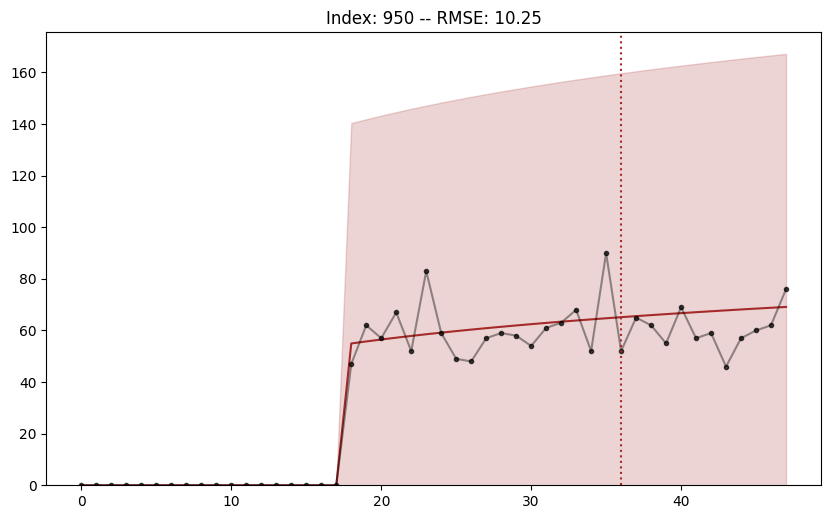

In [12]:
idx = np.random.randint(1, n_features)
idx = 950
range_x = np.arange(0, total_size)
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.fill_between(range_x, std_lower[:,idx], std_upper[:,idx], alpha = 0.2, color = "brown")
ax.plot(range_x, lin_curve[:,idx], color = "brown")
ax.plot(dataset[:,idx], "-", color = 'black', alpha = 0.4)
ax.plot(dataset[:,idx], ".", color = 'black', alpha = 0.7)
ax.axvline(x = hist_size, linestyle = ":", color = 'brown', label = 'Untrained data')
ax.set_title(f"Index: {idx} -- RMSE: {rmse_trend[idx]:.2f}")
ax.set_ylim(0)

##Season Finder

In [13]:
def moving_avg(arr, n, out_size, axis = 0):
    arr = np.tile(arr, (2, 1))
    shift = n - 1
    result = np.cumsum(arr, axis = axis)
    result[n:] = result[n:] - result[:-n]
    result = result[shift:] / n
    return result[time_cycle - n + int(n/2):out_size + time_cycle - n + int(n/2)]

In [14]:
seasonality = list()
dataset_reg = dataset - lin_curve
for i in range(dataset_reg.shape[0]):
    if (i > 11):
        break
    step_val = list()
    for step in range(int(hist_size/time_cycle)):
        step_val.append(dataset_reg[i + (step * time_cycle)])

    step_val = np.array(step_val).sum(axis = 0)
    step_val = np.nan_to_num(step_val / (hist_size/time_cycle))
    seasonality.append(step_val)

seasonality = np.asarray(seasonality)
seasonality = np.tile(seasonality, (int(total_size/time_cycle), 1))
seasonality_s = moving_avg(seasonality, 6, total_size)

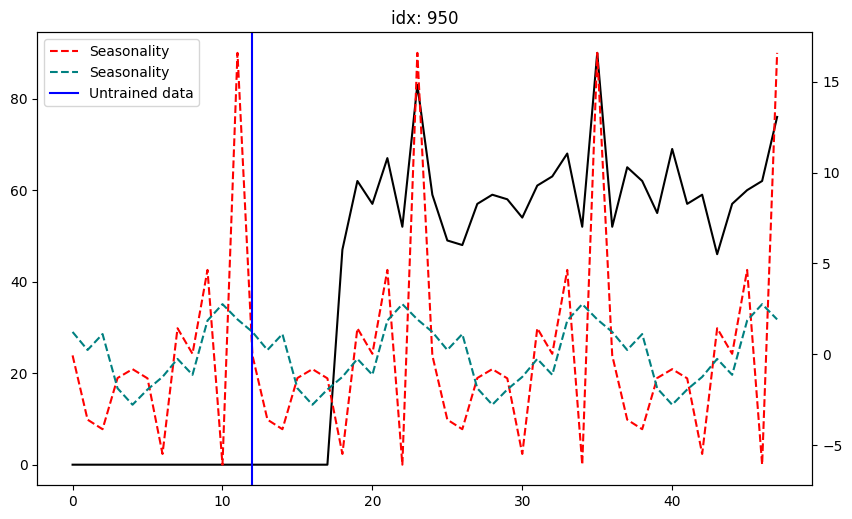

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=100)
ax2 = ax1.twinx()
idx = 950
ax1.plot(dataset[:,idx], '-', label = "Data", color = "black")
ax2.plot(seasonality[:,idx], '--', color = 'r', label = "Seasonality")
ax2.plot(seasonality_s[:,idx], '--', color = 'teal', label = "Seasonality")
plt.axvline(x = dataset.shape[0]-hist_size, color = 'b', label = 'Untrained data')
plt.title(f"idx: {idx}")
plt.legend(loc=2)
plt.show()

##Robust Regression

In [16]:
dataset_y = seasonality_s + lin_curve
dataset_y[dataset_y < 0] = 0
dataset_y = np.rint(dataset_y)
lower_bound = seasonality_s + std_lower
upper_bound = seasonality_s + std_upper
lower_bound[lower_bound < 0] = 0
upper_bound[upper_bound < 0] = 0
rmse_regression = sk_metrics.mean_squared_error(y_true = dataset[-lookback:],
                                                y_pred = dataset_y[-lookback:],
                                                squared = False,
                                                multioutput = "raw_values",
                                                )
print(rmse_regression.mean())

23.11408665964043


(0.0, 177.83809774367748)

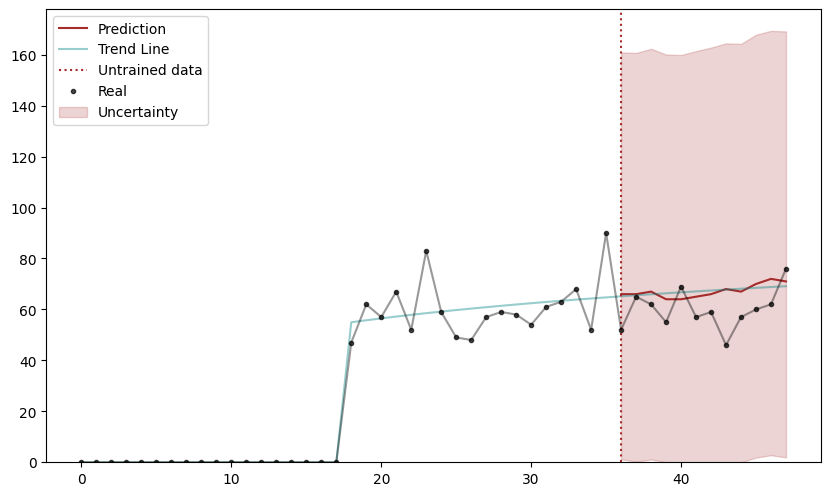

In [17]:
idx = np.random.randint(1, n_features)

#argsort = np.argsort(rmse_regression)
#idx = argsort[np.random.randint(0, 1000)]

idx = 950

range_x = np.arange(hist_size, total_size)
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.fill_between(range_x, upper_bound[-forecast_horizon:,idx], lower_bound[-forecast_horizon:,idx], alpha = 0.2, color = "brown", label = "Uncertainty")
ax.plot(range_x, dataset_y[-forecast_horizon:,idx], color = "brown", label = "Prediction")
ax.plot(lin_curve[:,idx], "-", color = 'teal', alpha = 0.4, label = "Trend Line")
ax.axvline(x = hist_size, linestyle = ":", color = 'brown', label = 'Untrained data')
ax.plot(dataset[:,idx], "-", color = 'black', alpha = 0.4)
ax.plot(dataset[:,idx], ".", color = 'black', alpha = 0.7, label = "Real")
#ax.set_title(f"Index: {idx} -- RMSE: {rmse_regression[idx]:.2f}")
plt.legend(loc = 2)
ax.set_ylim(0)

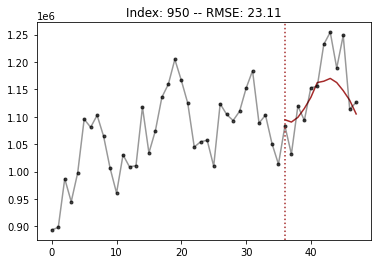

In [18]:
range_x = np.arange(hist_size, total_size)
#plt.fill_between(range_x, upper_bound[-forecast_horizon:].sum(axis = 1), lower_bound[-forecast_horizon:].sum(axis = 1), alpha = 0.2, color = "brown")
plt.plot(range_x, dataset_y[-forecast_horizon:].sum(axis = 1), color = "brown")
plt.plot(dataset.sum(axis = 1), "-", color = 'black', alpha = 0.4)
plt.plot(dataset.sum(axis = 1), ".", color = 'black', alpha = 0.7)
plt.axvline(x = hist_size, linestyle = ":", color = 'brown', label = 'Untrained data')
plt.title(f"Index: {idx} -- RMSE: {rmse_regression.mean():.2f}")
#plt.ylim(0)
plt.show()

##Training

In [19]:
dataset_xtrain = dataset_y[:-forecast_horizon]
dataset_ytrue = dataset.astype(float)[:-forecast_horizon]

scale = dataset_xtrain.max(axis = 0)
dataset_xtrain = np.divide(dataset_xtrain, scale, out=np.zeros_like(dataset_xtrain), where = scale!=0)
dataset_ytrue = np.divide(dataset_ytrue, scale, out=np.zeros_like(dataset_ytrue), where = scale!=0)

X_train, y_train = split_sequence(lookback, dataset_xtrain, dataset_ytrue, return_ys = True, flatten_samples = True)
X_train, y_train = X_train.transpose(), y_train.transpose()
X_train, y_train = np.expand_dims(X_train, axis = -1), np.expand_dims(y_train, axis = -1)

In [20]:
feats_dataset = feats.to_numpy()
feats_dataset = feats_dataset.repeat(X_train.shape[0] // n_features, axis = 0)
#feat_scale = feats_dataset.max(axis = 0)
#feats_dataset = np.divide(feats_dataset, feat_scale, out=np.zeros_like(feats_dataset), where = feat_scale!=0)
feats_dataset = np.expand_dims(feats_dataset, axis = -1)
feats_dim = feats_dataset.shape[1]

In [21]:
random_idx = np.arange(0, X_train.shape[0])
np.random.shuffle(random_idx)
X_train = X_train[random_idx]
y_train = y_train[random_idx]
feats_dataset = feats_dataset[random_idx]

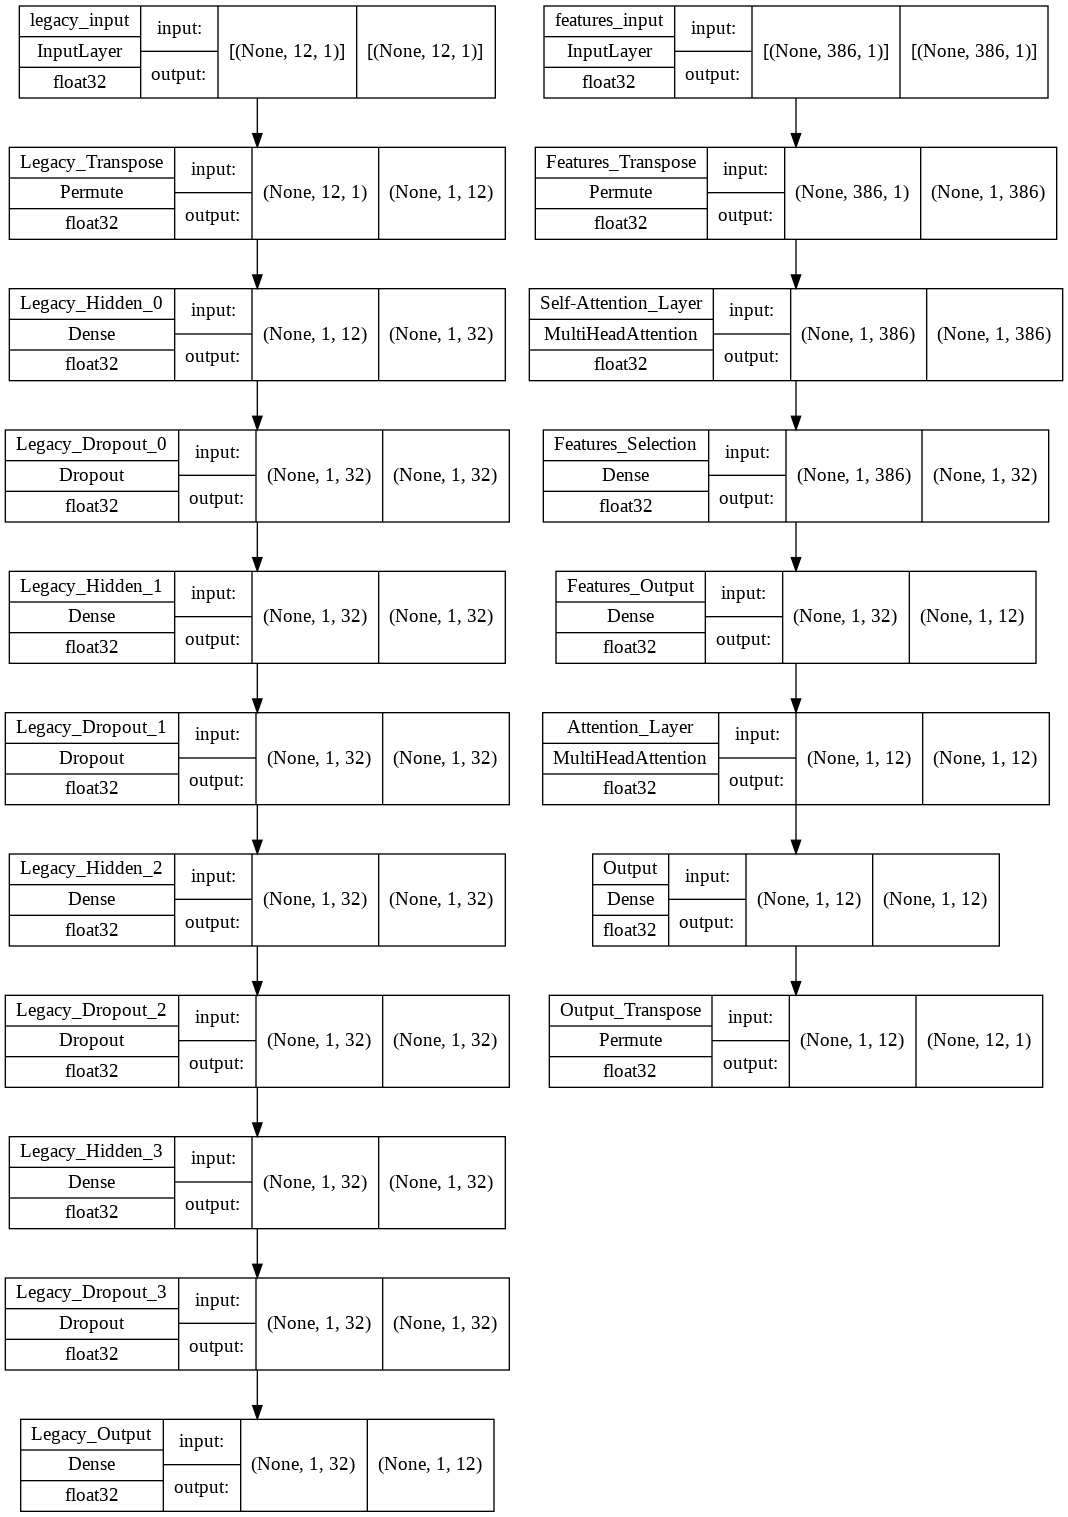

In [22]:
hidden_size = 32
num_heads = 4
key_dim = 8
dropout = 0.2
layers = 4

inputs_x = Input((forecast_horizon, 1), name = f"legacy_input")
x = tf.keras.layers.Permute((2, 1), name = f"Legacy_Transpose")(inputs_x)
for i in range(layers):
    x = Dense(hidden_size, name = f"Legacy_Hidden_{i}")(x)
    x = Dropout(dropout, name = f"Legacy_Dropout_{i}")(x, training = True)
x = Dense(forecast_horizon, activation = tf.keras.activations.tanh, name = f"Legacy_Output")(x)

inputs_z = Input((feats_dim, 1), name = f"features_input")
z = tf.keras.layers.Permute((2, 1), name = f"Features_Transpose")(inputs_z)
z = MultiHeadAttention(num_heads = num_heads, key_dim = key_dim, name = f"Self-Attention_Layer")(z, z)
#z = Dropout(dropout, name = f"Features_Dropout")(z, training = True)
z = Dense(hidden_size, name = f"Features_Selection")(z)
z = Dense(forecast_horizon, activation = tf.keras.activations.tanh, name = f"Features_Output")(z)

y = MultiHeadAttention(num_heads = num_heads, key_dim = key_dim, name = f"Attention_Layer")(query = z, value = x)
#y = Multiply()([x, z])
y = Dense(forecast_horizon, activation = tf.keras.activations.relu, name = "Output")(y)
y = tf.keras.layers.Permute((2, 1), name = "Output_Transpose")(y)

model = keras.Model([inputs_x, inputs_z], y, name = "DeepOracle")
model.compile(optimizer = "adam", loss = "mse")
#model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [23]:
try:
    model = keras.models.load_model(f'{master_path}best_model')
except:
    #trainer.fit(X_train, y_train, patience = 20, epochs = 10000, confusion = True, verbose = True)
    #trainer.plot_training()
    K.set_value(model.optimizer.learning_rate, 0.02)
    model.fit(x = [X_train, feats_dataset],
            y = y_train,
            batch_size = batch_size,
            epochs = 10000,
            validation_split = 0.9,
            #shuffle = True,
            callbacks = [
                         EarlyStopping(patience = 20, restore_best_weights = True, monitor = "val_loss"),
                         ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 5, verbose = 1)
                         ])
    model.save(f'{master_path}best_model')

##Evaluating

In [24]:
X_test = dataset_y[-forecast_horizon:]
X_test = np.divide(X_test, scale, out=np.zeros_like(X_test), where = scale!=0).transpose()
X_test = np.expand_dims(X_test, axis = -1)

feats_dataset = feats.to_numpy()
feat_scale = feats_dataset.max(axis = 0)
feats_dataset = np.divide(feats_dataset, feat_scale, out=np.zeros_like(feats_dataset), where = feat_scale!=0)
feats_dataset = np.expand_dims(feats_dataset, axis = -1)

quantiles = 15
yhat = list()
for yq in tqdm(range(100)):
    yhat.append(model.predict([X_test, feats_dataset], 
                              verbose = False, 
                              batch_size = batch_size).reshape((n_features, forecast_horizon)).transpose()
                              )
yhat = np.array(yhat)
yhat = np.quantile(yhat, np.arange(0, 1, 1/quantiles), axis = 0)
yhat = yhat * scale
y_test = dataset[-forecast_horizon:]

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
rmse = sk_metrics.mean_squared_error(y_true = y_test,
                                     #y_pred = yhat[yhat.shape[0] // 2],
                                     y_pred = yhat.mean(axis = 0),
                                     squared = False,
                                     multioutput = "raw_values",
                                     )
rmse.mean()

22.692414300752862

In [26]:
mae = sk_metrics.mean_absolute_error(y_true = y_test,
                                     #y_pred = yhat[yhat.shape[0] // 2],
                                     y_pred = yhat.mean(axis = 0),
                                     multioutput = "raw_values",
                                     )
mae.mean()

19.161244483599

In [27]:
mape = MAPE(y_test,
            yhat.mean(axis = 0),
            axis = 0).numpy()

mape.mean() * 100

53.74847650527954

In [28]:
idx = 21500
idx = 950
idx = 6631
idx = 18490

9897

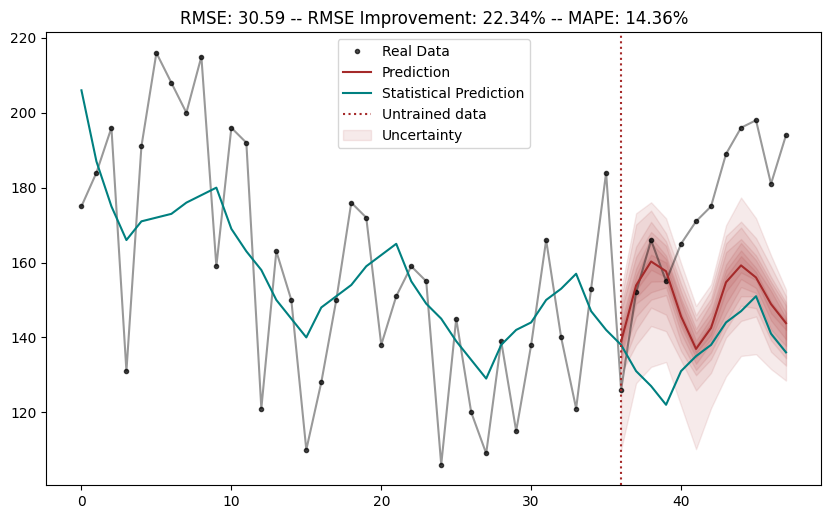

In [39]:
#idx = np.random.randint(0, n_features)
argsort = np.argsort(mape)
idx = argsort[np.random.randint(0, 1000)]
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
range_x = np.arange(hist_size, total_size)
ax.plot(dataset[:,idx], "-", color = 'black', alpha = 0.4)
ax.plot(dataset[:,idx], ".", color = 'black', alpha = 0.7, label = f"Real Data")
for i in range(yhat.shape[0] // 2):
    if (i == 0):
        ax.fill_between(range_x, yhat[-i-1,:,idx], yhat[i,:,idx], alpha = 0.7 / (yhat.shape[0] / 2), color = "brown", label = f"Uncertainty")
    else:
        ax.fill_between(range_x, yhat[-i-1,:,idx], yhat[i,:,idx], alpha = 0.7 / (yhat.shape[0] / 2), color = "brown")
ax.plot(range_x, yhat[yhat.shape[0] // 2,:,idx], color = "brown", label = f"Prediction")
ax.plot(dataset_y[:,idx], color = "teal", label = f"Statistical Prediction")
ax.axvline(x = hist_size, linestyle = ":", color = 'brown', label = 'Untrained data')
ax.set_title(f"RMSE: {rmse[idx]:.2f} -- RMSE Improvement: {(1-(rmse[idx] / rmse_regression[idx]))*100:.2f}% -- MAPE: {mape[idx]*100:.2f}%")
plt.plot()
plt.legend()
idx

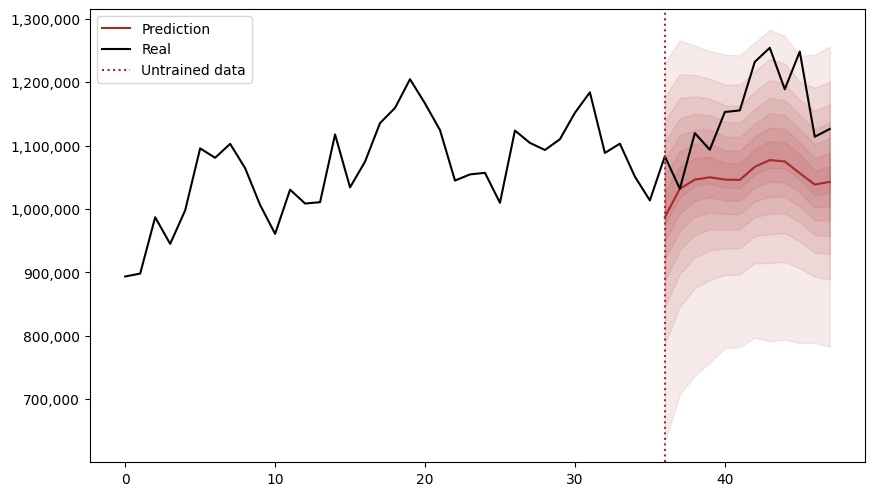

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
idx = np.random.randint(0, n_features)
range_x = np.arange(hist_size, total_size)
for i in range(yhat.shape[0] // 2):
    ax.fill_between(range_x, yhat[-i-1,:].sum(axis = 1), yhat[i,:].sum(axis = 1), alpha = 0.7 / (yhat.shape[0] / 2), color = "brown")
ax.plot(range_x, yhat.mean(axis = 0).sum(axis = 1), color = "brown", label = "Prediction")
ax.plot(dataset.sum(axis = 1), "-", color = 'black', label = "Real")
ax.axvline(x = hist_size, linestyle = ":", color = 'brown', label = 'Untrained data')
#ax.set_title(f"Index: {idx} -- RMSSE: {rmse.mean():.2f}")
#plt.ylim(0)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend()
plt.show()

#TFT (W/O Covariates)

##Imports

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from sktime.performance_metrics.forecasting import mean_squared_scaled_error as RMSSE

##Data Preparation

In [ ]:
data = df.copy()
data["month"] = data["month"].astype(str).astype("category")
data["log_volume"] = np.log(data["sales"] + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "id"], observed=True)["sales"].transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "dept_id"], observed=True)["sales"].transform("mean")

In [ ]:
max_prediction_length = lookback
max_encoder_length = forecast_horizon
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="sales",
    group_ids=['id', 'item_id', 'dept_id', 'cat_id',  'store_id', 'state_id'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['id', 'item_id', 'dept_id', 'cat_id',  'store_id', 'state_id'],
    static_reals=[],
    time_varying_known_categoricals=["month"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "sales",
        "log_volume",
        "avg_volume_by_sku",
        "avg_volume_by_agency"
    ],
    target_normalizer=GroupNormalizer(
        groups=['id', 'item_id', 'dept_id', 'cat_id',  'store_id', 'state_id'], transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

##Training

In [ ]:
if (USE_LR_FINDER):
    pl.seed_everything(42)
    trainer = pl.Trainer(
        #gpus=1,
        gradient_clip_val=0.1,
    )

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.03,
        hidden_size=16,
        attention_head_size=4,
        dropout=0.1,
        hidden_continuous_size=8,
        output_size=1,
        loss=RMSE(),
        reduce_on_plateau_patience=4,
    )
    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    res = trainer.tuner.lr_find(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
        max_lr=10.0,
        min_lr=1e-6,
    )

    print(f"suggested learning rate: {res.suggestion()}")
    fig = res.plot(show=True, suggest=True)
    fig.show()

In [ ]:
if (TRAIN_MODEL):
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()
    #logger = TensorBoardLogger("lightning_logs")

    trainer = pl.Trainer(
        max_epochs=200,
        gpus=1,
        weights_summary="top",
        gradient_clip_val=0.1,
        limit_train_batches=30,
        callbacks=[lr_logger, early_stop_callback]
    )


    tft = TemporalFusionTransformer.from_dataset(
        training,
        #learning_rate=6.918309709189363e-06,
        learning_rate=0.001,
        hidden_size=16,
        attention_head_size=4,
        dropout=0.1,
        hidden_continuous_size=8,
        output_size=1,  # 7 quantiles by default
        loss=RMSE(),
        log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
        reduce_on_plateau_patience=4,
    )
    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 536 K 
3  | prescalers                         | ModuleDict                      | 144   
4  | static_variable_selection          | Variabl

Number of parameters in network: 558.6k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

##Evaluating

In [ ]:
dataset = df[["id", "time_idx", "sales"]]
dataset = pd.pivot_table(dataset, index = "time_idx", columns = "id", values = "sales")
dataset = dataset.to_numpy()
dataset_train = dataset[:-forecast_horizon]
dataset_test = dataset[-forecast_horizon:]
predictions = tft.predict(val_dataloader)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
actuals = np.asarray(actuals).transpose()
dataset_pred = np.vstack([dataset[:-forecast_horizon], np.asarray(predictions).transpose()])

In [ ]:
rmse_tft = sk_metrics.mean_squared_error(y_true = actuals, 
                                     y_pred = dataset_pred[-forecast_horizon:],
                                     squared = False,
                                     multioutput = "raw_values",
                                     )

rmse_tft.mean()

23.54188509038225

In [ ]:
mape_tft = MAPE(actuals, dataset_pred[-forecast_horizon:]).numpy()
mape_tft.mean()

0.5456574

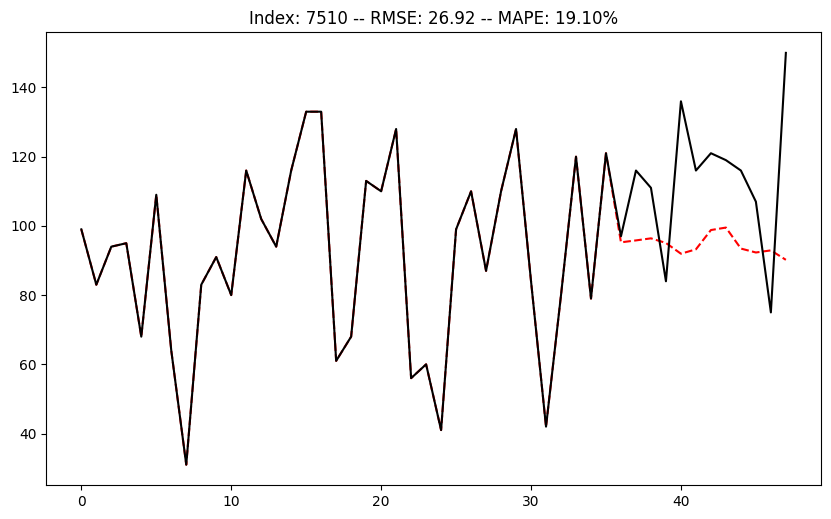

In [ ]:
idx = np.random.randint(0, dataset_train.shape[1])
#idx = np.argsort(rmse)[np.random.randint(0, 50)]
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.plot(dataset_pred[:,idx], "--", color = "r")
ax.plot(np.hstack([dataset[:-forecast_horizon,idx], actuals[:,idx]]), "-", color = "black")
ax.set_title(f"Index: {idx} -- RMSE: {rmse_tft[idx]:.2f} -- MAPE: {mape_tft[idx]*100:.2f}%")
plt.show()

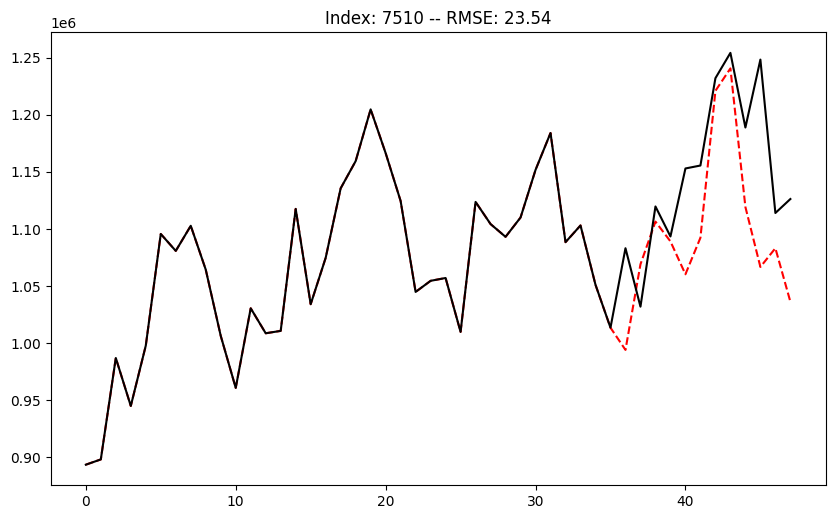

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.plot(dataset_pred.sum(axis = 1), "--", color = "r")
ax.plot(np.vstack([dataset[:-forecast_horizon], actuals]).sum(axis = 1), "-", color = "black")
ax.set_title(f"Index: {idx} -- RMSE: {rmse_tft.mean():.2f}")
plt.show()

In [ ]:
raw_prediction, x = tft.predict(
    val_dataloader,
    mode="raw",
    return_x=True,
)

In [ ]:
interpretation = tft.interpret_output(raw_prediction, reduction="sum")
tft.plot_interpretation(interpretation)

#NBeats

##imports

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder, GroupNormalizer
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE, RMSE

##Data Preparation

In [ ]:
data = df
data["month"] = data["month"].astype(str).astype("category")
data = data[["time_idx", "id", "sales"]]

In [ ]:
max_prediction_length = lookback
max_encoder_length = forecast_horizon
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="sales",
    categorical_encoders={"id": NaNLabelEncoder().fit(data.id)},
    group_ids=["id"],
    time_varying_unknown_reals=["sales"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    target_normalizer=GroupNormalizer(groups=["id"], transformation="softplus"),
)


validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

##Training

In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=1, 
                     gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1, loss = RMSE())

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/.lr_find_9cf6983d-4853-42ea-b505-83ca9bcc82b4.ckpt


suggested learning rate: 0.00014125375446227546


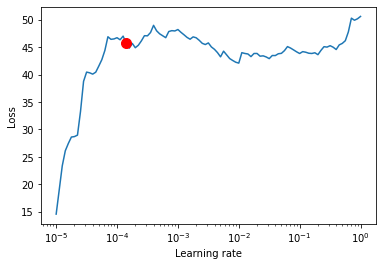

In [ ]:
if(True):
    res = trainer.tuner.lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
    print(f"suggested learning rate: {res.suggestion()}")
    fig = res.plot(show=True, suggest=True)
    fig.show()
    net.hparams.learning_rate = res.suggestion()

In [ ]:
if (TRAIN_MODEL):
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

    trainer = pl.Trainer(
        max_epochs=100,
        gpus=1,
        weights_summary="top",
        gradient_clip_val=0.01,
        callbacks=[early_stop_callback],
        limit_train_batches=30,
    )


    net = NBeats.from_dataset(
        training,
        learning_rate=0.00014125375446227546,
        log_interval=10,
        log_val_interval=1,
        weight_decay=1e-2,
        widths=[32, 512],
        backcast_loss_ratio=1.0,
        loss = RMSE()
    )

    trainer.fit(
        net,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

best_model_path = best_model_path = f"{master_path}TrainingData/nbeats.ckpt"
net = NBeats.load_from_checkpoint(best_model_path)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | RMSE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.489     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

##Evaluating

In [ ]:
dataset = df[["id", "time_idx", "sales"]]
dataset = pd.pivot_table(dataset, index = "time_idx", columns = "id", values = "sales")
dataset = dataset.to_numpy()
dataset_train = dataset[:-forecast_horizon]
dataset_test = dataset[-forecast_horizon:]
predictions = net.predict(val_dataloader)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
actuals = np.asarray(actuals).transpose()
dataset_pred = np.vstack([dataset[:-forecast_horizon], np.asarray(predictions).transpose()])

In [ ]:
rmse_nbeats = sk_metrics.mean_squared_error(y_true = actuals, 
                                     y_pred = dataset_pred[-forecast_horizon:],
                                     squared = False,
                                     multioutput = "raw_values",
                                     )

rmse_nbeats.mean()

25.95099649677906

In [ ]:
mape_nbeats = MAPE(actuals, dataset_pred[-forecast_horizon:], axis = 0).numpy()
mape_nbeats.mean()

0.5823294

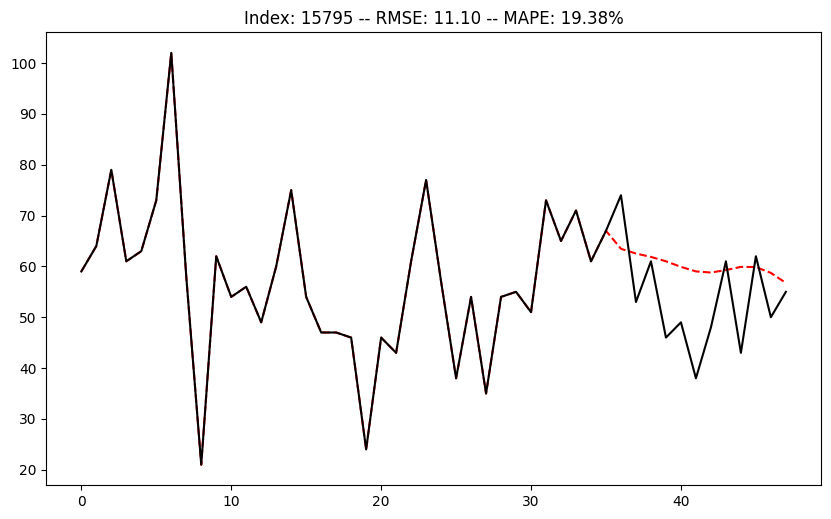

In [ ]:
idx = np.random.randint(0, dataset_train.shape[1])
#idx = np.argsort(rmse)[np.random.randint(0, 50)]
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.plot(dataset_pred[:,idx], "--", color = "r")
ax.plot(np.hstack([dataset_pred[:-forecast_horizon,idx], actuals[:,idx]]), "-", color = "black")
ax.set_title(f"Index: {idx} -- RMSE: {rmse_nbeats[idx]:.2f} -- MAPE: {mape_nbeats[idx]*100:.2f}%")
plt.show()

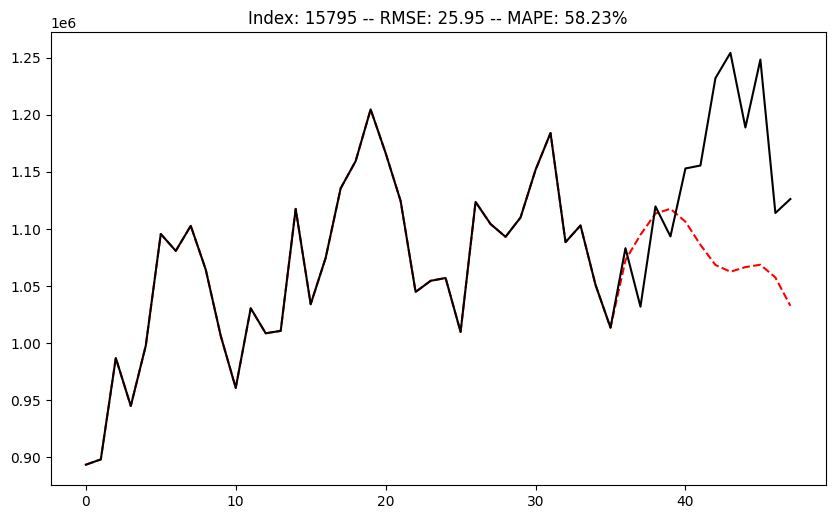

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.plot(dataset_pred.sum(axis = 1), "--", color = "r")
ax.plot(np.vstack([dataset[:-forecast_horizon], actuals]).sum(axis = 1), "-", color = "black")
ax.set_title(f"Index: {idx} -- RMSE: {rmse_nbeats.mean():.2f} -- MAPE: {mape_nbeats.mean()*100:.2f}%")
plt.show()